<a href="https://colab.research.google.com/github/Danilov-Aleksandr/CV_Korpus/blob/master/inclass_%D0%9F%D0%B5%D1%80%D0%B5%D0%BD%D0%BE%D1%81_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Классификация котиков и собачек**

---

In [ ]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import copy
import tqdm
import time
from PIL import Image

import albumentations
from albumentations import pytorch as AT



%matplotlib inline

## Загружаем и подготавливаем данные

Пример подготовки данных для обучения нейронной сети на Pytorch. Данные разбиваются на три части:

train (данные для обучения)
val (данные для проверки)
test (данные для тестирования)

Перед запуском необходимо добавить к себе на диск файл dogs-vs-cats.zip с набором изображений кошек и собак Dogs vs. Cats.

In [ ]:
# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Распаковка датасета
with zipfile.ZipFile('/content/drive/My Drive/dogs-vs-cats.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')
  
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

with zipfile.ZipFile('/content/test1.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

In [ ]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [ ]:
print(len(train_files), len(test_files))

25000 12500


In [ ]:
train_files[:10]

['cat.7614.jpg',
 'dog.1875.jpg',
 'cat.10747.jpg',
 'dog.1882.jpg',
 'cat.7992.jpg',
 'cat.6025.jpg',
 'dog.7905.jpg',
 'dog.12203.jpg',
 'dog.1721.jpg',
 'cat.6907.jpg']

Самое время заняться классом Dataset:

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, transform=None):
        self.file_list = file_list
        self.dir = dir
        self.transform = transform


            
    def __len__(self):
        return len(self.file_list)
    
    #метод который позволяет нам индексировать датасет
    def __getitem__(self, idx):
        #считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_list[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if 'dog' in self.file_list[idx]:
            self.label = 1
        else:
            self.label = 0
        #применяем аугментации
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, float(self.label)




In [ ]:
#зададим немного гиперпараметров
batch_size = 32
num_workers = 0
img_size = 256


In [ ]:
#Пример того как выглядит обычно набор аугментаций. 
#В зависимости от задачи может отличаться количеством и сложностью.

data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

#обычно аугментации для трейн и тест датасетов разделают. 
#На тесте обычно не нужно сильно изменять изображения
data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

In [ ]:
#Инициализируем датасеты
trainset = CatDogDataset(train_files, train_dir, transform = data_transforms)
testset = CatDogDataset(test_files, test_dir, transform=data_transforms_test)

In [ ]:
#Разделим трейновую часть на трейн и валидацию. Попробуем другой способ.
valid_size = int(len(train_files) * 0.1)
train_set, valid_set = torch.utils.data.random_split(trainset, 
                                    (len(train_files)-valid_size, valid_size))

In [ ]:
len(train_set), len(valid_set)

(22500, 2500)

In [ ]:
#создаем даталоадеры для всех 3х подвыборок.
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

validloader = torch.utils.data.DataLoader(valid_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         num_workers = num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
       dtype=torch.float64)


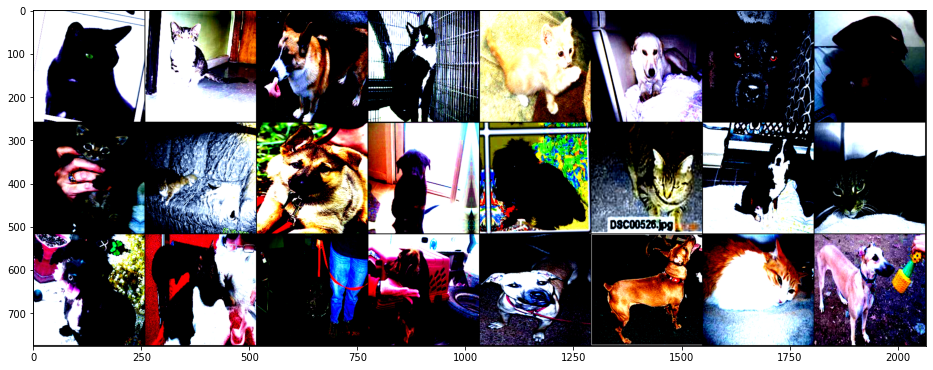

In [ ]:
#Проверим работоспособность
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

Импортируем готовую модель!

In [ ]:
model = torchvision.models.resnet50(pretrained=True, progress=True)
model

In [ ]:
model = torchvision.models.resnet18(pretrained=True, progress=True)
#model.load_state_dict(torch.load('/content/drive/My Drive/resnet50.pth'))
for param in model.parameters():
    param.requires_grad = False
# в этот раз будем обучать бинарную классификацию, поэтому 1 выход.
model.fc = nn.Linear(512, 1)

In [ ]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, scheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False

    # количество эпох
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device).unsqueeze(1)
            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
    # запускаем валидацию
        model_conv.eval()
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).unsqueeze(1)
            output = model_conv(data)
            loss = criterion(output, target.float())
            val_loss.append(loss.item()) 

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            p = 0

        # проверяем как дела на валидации
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv, train_loss, val_loss

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2,)

In [ ]:
model_resnet, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, 
                              optimizer,scheduler,  n_epochs=5,)

Thu Aug 20 15:15:37 2020 Epoch: 1


KeyboardInterrupt: ignored

In [ ]:
model.state_dict(torch.load('/content/model.pt')); 

In [ ]:
th = 0.2
model.to(device)
model.eval()
pred_list = []
for x, _ in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.sigmoid(output)
        pred = pred.cpu().detach().numpy()
        pred = np.where(pred>th, 1, 0) 
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"label":pred_list})
submission.to_csv('preds.csv', index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]


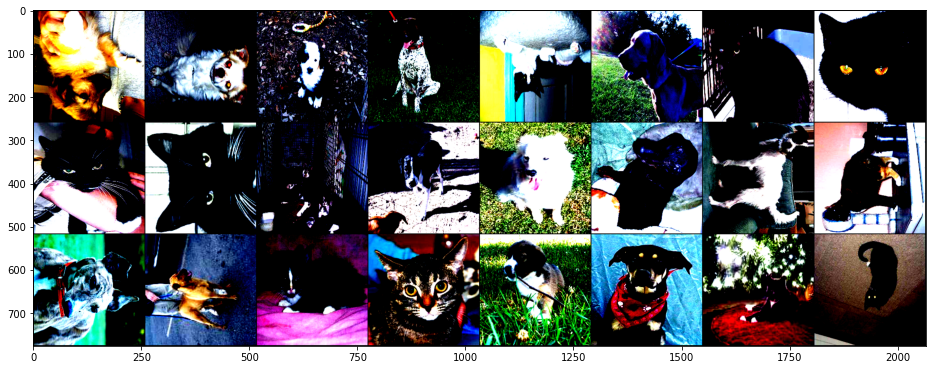

In [ ]:
x, _ = next(iter(testloader))
x = x.to(device)
model.to(device)
output = model(x)
pred = torch.sigmoid(output)
th = 0.4
pred = pred.cpu().detach().numpy()
pred = np.where(pred>th, 1, 0)
print([p.item() for p in pred])
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(x[:24])
np_grid_imgs = grid_imgs.cpu().numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
